In [1]:
import os 
import sys
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import lognorm
from scipy.stats import norm 
from scipy import integrate
from scipy.stats import gmean

from scipy.stats import pearsonr

import statsmodels.api as sm 
import statsmodels.formula.api as smf

### src; https://github.com/arkottke/pyrotd
import pyrotd



In [2]:
with open('BuildingNames.txt', 'r') as f:
    BuildingList = f.read() 
BuildingList = BuildingList.split('\n')
BuildingList

['s1_48x32_high',
 's1_48x32_veryhigh',
 's1_96x48_high',
 's1_96x48_veryhigh',
 's2_48x32_high',
 's2_48x32_veryhigh',
 's2_96x48_high',
 's2_96x48_veryhigh',
 's4_96x48_high',
 's4_96x48_veryhigh']

In [3]:
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'

## time period of the buildings
T = np.array([0.13, 0.12, 0.22, 0.22, 0.16, 0.15, 0.26, 0.25, 0.49, 0.49])

numGM = 826
g = 980.665 ## converts GM record to cm/sec^2

def compute_RotDxx_EDP(edpX, edpZ, percentile = 50):
    angles = np.arange(0, 180, step=1)
    radians = np.radians(angles)
    coeffs = np.c_[np.cos(radians), np.sin(radians)]
    
    edp_stacked = np.vstack([edpX, edpZ])
    rotated_edp = np.dot(coeffs, edp_stacked)
    percentile_edp = np.percentile(rotated_edp, q = percentile, axis = 0, interpolation='linear')
    return percentile_edp

In [4]:
# heresi_GM_dir = os.path.join(baseDir, *['References', 'Heresi GMs'])
# os.chdir(heresi_GM_dir)
# heresiGM = pd.read_csv('Ground Motion Records.csv')
# RSNs = heresiGM['Record Sequence Number\n(NGA-West2)'].values
# np.savetxt('Heresi_831_RSNs.txt',[RSNs], delimiter=',', fmt='%d')

In [5]:
gminfo_h1 = pd.read_csv(r'data/Complete_GM_info_h1.csv')
gminfo_h1 = gminfo_h1.set_index('key_0')
gminfo_h1.index.names = ['GMID']

In [6]:
gminfo_h2 = pd.read_csv(r'data/Complete_GM_info_h2.csv')
gminfo_h2 = gminfo_h2.set_index('key_0')
gminfo_h2.index.names = ['GMID']

In [7]:
gminfo_rotD50 = pd.read_csv(r'data/Complete_GM_info_RotD50.csv')
gminfo_rotD50 = gminfo_rotD50.set_index('key_0')
gminfo_rotD50.index.names = ['GMID']
gminfo_rotD50.columns

Index(['PGA', 'PGV', 'DS_5to75', 'DS_5to95', 'CAV', 'T_0.01', 'T_0.02',
       'T_0.03', 'T_0.04', 'T_0.05',
       ...
       'SI', 'ASI', 'DSI', 'Sa_avg', '5-75% Duration (sec)_NGA2',
       '5-95% Duration (sec)_NGA2', 'Magnitude', 'Distance_Rjb',
       'Distance_rup', 'Vs_30'],
      dtype='object', length=156)

In [8]:
sv_rotD50 = pd.read_csv('data/Spectral_velocity_rotD50.csv', index_col='GMID')
sd_rotD50 = pd.read_csv('data/Spectral_Displacement_rotD50.csv', index_col='GMID')

In [9]:
# os.chdir(os.path.join(baseDir, *['Codes', 'data']))
# np.savetxt('Magnitude.txt', gminfo_rotD50['Magnitude'].values, fmt = '%.3f')
# np.savetxt('Distance_Rjb.txt', gminfo_rotD50['Distance_Rjb'].values, fmt = '%.3f')

## Defining Classes for efficiency and sufficiency

In [10]:
class OLS:
    def __init__(self, EDP, IM):
        self.EDP = EDP
        self.IM = IM
        self.Y = np.log(EDP)
        self.X = sm.add_constant(np.log(IM))
        
        self.residual_mean = None
        self.residual_std = None
        self.xmin = None
        self.xmax = None
        
        self.fitModel()
        self.get_summary()
        
#         self.plot_residuals_hist()
#         self.plot_model_fit()
        
    def fitModel(self):
        model = sm.OLS(self.Y, self.X)
        self.result = model.fit()
        
    def get_summary(self):
        return self.result.summary()
    
    def plot_residuals_hist(self):
        fig, ax = plt.subplots()
        sns.histplot(x = self.result.resid, ax=ax, stat = 'density', linewidth = 0, kde=True)
        ax.set(title = 'Distribution of residuals', xlabel = 'residuals')
        
        self.residual_mean, self.residual_std = norm.fit(self.result.resid)
        ##plotting normal pdf
        self.xmin, self.xmax = plt.xlim() # using maxi/min values from histogram
        x = np.linspace(self.xmin, self.xmax, 200)
        pdf = norm.pdf(x, self.residual_mean, self.residual_std)
        sns.lineplot(x = x, y = pdf, color = 'red', ax = ax)
        plt.show()
    
    def get_efficiency(self):
        return np.std(self.result.resid)
            
    def qqplot(self):
        sm.qqplot(self.result.resid, line = 's')


    def fitplot(self):
        sm.graphics.plot_fit(self.result, 1, vlines = False);
        
    def plot_model_fit(self):
        Ymin = self.Y.min()
        Ymax = self.Y.max()
#         ax = sns.subplots()
        ax = sns.scatterplot(x = self.result.fittedvalues, y = self.Y)
#         ax.set_ylim(Ymin, Ymax)
#         ax.set_xlim(self.xmin, self.xmax)
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Observed Values')
        
        X_ref = Y_ref = np.linspace(Ymin, Ymax, 200)
        plt.plot(X_ref, Y_ref, color = 'red', linewidth = 1.3)
        plt.show()
        
class Sufficiency():
    def __init__(self, ln_EDP, ln_IM, Rjb, Mag):
        self.EDP = ln_EDP
        self.IM = ln_IM
        self.X = sm.add_constant(self.IM)
        
        temp = {'I': np.ones(shape = len(Mag)),
                'lnEDP': self.EDP,
                'lnIM': self.IM,
                'lnRjb': np.log(Rjb),
                'M': Mag}
        self.dummydf = pd.DataFrame(temp, index = None)
        
        self.sufficiency_against_R()
        self.sufficiency_against_M()
        self.sufficiency_against_M_and_R()
        
    def sufficiency_against_R(self):
        self.model_IM_vs_R = smf.ols('lnEDP ~ lnIM + lnRjb', data = self.dummydf)
        model_res = self.model_IM_vs_R.fit()
        self.summary_against_R = model_res.summary()
        return model_res.pvalues['lnRjb']
        
    def sufficiency_against_M(self):
        self.model_IM_vs_M = smf.ols('lnEDP ~ lnIM + M', data = self.dummydf)
        model_res = self.model_IM_vs_M.fit()
        self.summary_against_M = model_res.summary()
        return model_res.pvalues['M']

    def sufficiency_against_M_and_R(self):
        self.model_IM_vs_R_and_M = smf.ols('lnEDP ~ lnIM + M + lnRjb', data = self.dummydf)
        model_res = self.model_IM_vs_R_and_M.fit()
        self.summary_against_M_and_R = model_res.summary()
        return model_res.pvalues
    
    def qqplot(self, model):
        sm.qqplot(model.fit(), line = 's')
      

In [11]:
def SummaryResutls_efficiency(buildingIndex, df_IMs, IMs=['SaT1', 'PGA', 'PGV', 'Sa_avg'],
                              pairingID = 1, average_EDP = False, rotate_EDP = False):
    '''
    pairingID: if 1, GM_h1 applied in X-direction, GM_h2 applied in Y-direction
               if 2, GM_h2 applied in X-direction, GM_h1 applied in Y-direction
               
    Note:
    Care must be taken while using gminfo and pairing ID
    -------------
    df_IMs = gminfo_RotD50 can be used with pairing ID 1 OR 2 
    df_IMs = gminfo_h1 can only be used with pairing ID 1
    df_IMs = gminfo_h2 can only be used with pairing ID 2
    '''
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    sdr = pd.read_csv('SDR.csv', header = None)
    pfa = pd.read_csv('PFA.csv', header = None)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    tempdf = []
    d = []
    keys = ['1st Story', '2nd Story', '3rd Story', '4th Story']
    temp_sdr = {}
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
    
    for i in range(len(IMs)):
        if IMs[i] == 'SaT1':
            IM = df_IMs['T_%s'%T[buildingIndex]].values
            ######### result for SaT1, SvT1 and SdT1 is the same b/c they are constantly relate
#         elif IMs[i] == 'SvT1':
#             IM = sv_rotD50['T_%s'%T[buildingIndex]].values
#         elif IMs[i] == 'SdT1':
#             IM = sd_rotD50['T_%s'%T[buildingIndex]].values
        else:
            IM = df_IMs[IMs[i]]

        for j in range(numStory):
            
            sdrX = sdr[3+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            sdrZ = sdr[3+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

            pfaX = pfa[4+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            pfaZ = pfa[4+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
            
            if average_EDP:
                sdrX_avg = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
                pfaX_avg = gmean([pfa[4+j].values[0:numGM], pfa[4+j].values[numGM*2:numGM*3]])
                
                sdrZ_avg = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
                pfaZ_avg = gmean([pfa[4+j].values[numGM:numGM*2], pfa[4+j].values[numGM*3:numGM*4]])
#                 compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
#                 pfa_rotD50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
                if rotate_EDP:
                    sdr_rotD50 = compute_RotDxx_EDP(sdrX_avg, sdrZ_avg, percentile=50)
                    pfa_rotD50 = compute_RotDxx_EDP(pfaX_avg, pfaZ_avg, percentile=50)
                    ols_sdrX = OLS(sdr_rotD50, IM)
                    ols_pfaZ = OLS(pfa_rotD50, IM)
                    temp_sdr[keys[j]] = {'SDR_RotD50':ols_sdrX.get_efficiency(),
                                         'PFA_RotD50': ols_pfaZ.get_efficiency()}
                else:
                    ols_sdrX = OLS(sdrX_avg, IM)
                    ols_sdrZ = OLS(sdrZ_avg, IM)
                    ols_pfaX = OLS(pfaX_avg, IM)
                    ols_pfaZ = OLS(pfaZ_avg, IM)
                    temp_sdr[keys[j]] = {'SDR_X_Avg':ols_sdrX.get_efficiency(),
                                         'SDR_Z_Avg':ols_sdrZ.get_efficiency(),
                                         'PFA_X_Avg': ols_pfaX.get_efficiency(),
                                         'PFA_Z_Avg': ols_pfaZ.get_efficiency()}
            else:
                ols_sdrX = OLS(sdrX, IM)
                ols_sdrZ = OLS(sdrZ, IM)
                ols_pfaX = OLS(pfaX, IM)
                ols_pfaZ = OLS(pfaZ, IM)
                temp_sdr[keys[j]] = {'SDR_X':ols_sdrX.get_efficiency(),
                                     'SDR_Z':ols_sdrZ.get_efficiency(),
                                     'PFA_X': ols_pfaX.get_efficiency(),
                                     'PFA_Z': ols_pfaZ.get_efficiency()}
        reform = {(outerKey, innerKey): values for outerKey, innerDict in temp_sdr.items() for innerKey, values in innerDict.items()}
        df = pd.DataFrame.from_dict(reform, orient='index').transpose()
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        df['IM'] = IMs[i]
        df = df.set_index('IM')
        tempdf.append(df)

    return pd.concat(tempdf)


In [12]:
# buildingIndex = 2
# IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI', 'SvT1', 'SdT1']
# for i in range(len(IM_list)):
#     print(IM_list[i])
#     if IM_list[i] == 'SaT1':
#         IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
#     elif IM_list[i] == 'SvT1':
        
#         IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
#         print('YES')
#     elif IM_list[i] == 'SD':
#         print('YES')
#         IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
#     else:
#         IM = gminfo_rotD50[IM_list[i]]

In [13]:
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True)
s1_48x32_high

1st Story                               2nd Story            \
         SDR_X_Avg SDR_Z_Avg PFA_X_Avg PFA_Z_Avg SDR_X_Avg SDR_Z_Avg   
IM                                                                     
SaT1      0.306560  0.298939  0.212809  0.299464  0.251068  0.258472   
PGA       0.345271  0.340625  0.202065  0.193986  0.286287  0.296319   
PGV       0.367408  0.367921  0.515318  0.613536  0.365682  0.376729   
Sa_avg    0.301730  0.294439  0.161258  0.236964  0.243988  0.249735   
CAV       0.417079  0.412715  0.531557  0.611540  0.412766  0.417970   
SI        0.339409  0.340051  0.473371  0.591283  0.338039  0.347350   
ASI       0.354667  0.344909  0.202595  0.146872  0.295303  0.295745   
DSI       0.496463  0.495303  0.740959  0.839590  0.522509  0.524311   
DS_5to75  0.564611  0.557460  0.728583  0.761745  0.559859  0.566147   
DS_5to95  0.567675  0.562252  0.768982  0.815194  0.571739  0.579923   

                             3rd Story                                \
         PFA_X_Avg PFA_Z_Avg SDR_X_Avg SDR_Z_Avg PFA_X_Avg PFA_Z_Avg   
IM                                                                     
SaT1      0.180937  0.291670  0.277566  0.280441  0.184343  0.284668   
PGA       0.221042  0.211531  0.286733  0.294519  0.225105  0.216176   
PGV       0.484165  0.601925  0.385978  0.393045  0.471412  0.582273   
Sa_avg    0.162919  0.244688  0.259856  0.263950  0.178400  0.243784   
CAV       0.500670  0.593449  0.430475  0.434717  0.480714  0.571337   
SI        0.444218  0.582619  0.360086  0.366708  0.437628  0.564052   
ASI       0.200995  0.137543  0.294913  0.294538  0.187416  0.131668   
DSI       0.689372  0.810814  0.531423  0.534828  0.653743  0.779571   
DS_5to75  0.681707  0.733470  0.545112  0.549292  0.632733  0.705341   
DS_5to95  0.717794  0.781498  0.555757  0.562545  0.667109  0.748829   

         4th Story                                
         SDR_X_Avg SDR_Z_Avg PFA_X_Avg PFA_Z_Avg  
IM                                                
SaT1      0.240318  0.239300  0.237981  0.298973  
PGA       0.221077  0.220843  0.231202  0.229705  
PGV       0.560894  0.560785  0.523527  0.596837  
Sa_avg    0.211794  0.212310  0.221485  0.260257  
CAV       0.559970  0.560207  0.512541  0.578204  
SI        0.530075  0.529516  0.498297  0.580770  
ASI       0.158508  0.160452  0.170618  0.129147  
DSI       0.765662  0.766305  0.701073  0.787492  
DS_5to75  0.710706  0.710949  0.655283  0.709765  
DS_5to95  0.754975  0.755489  0.696806  0.755352

In [ ]:
s1_48x32_high.min().min()


In [ ]:
s1_48x32_high.iloc[:, 0].values

In [ ]:
s1_48x32_high.iloc[:, 1].values[:2]

In [ ]:
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax1.bar3d(x = [0.1, 0.3], y = [0.5,0.7], z = [1],
          dx = s1_48x32_high.iloc[:, 0].values[:2], dy = s1_48x32_high.iloc[:, 1].values[:2], dz = [0, 1])

In [ ]:
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
color_pallet = ['b', 'g', 'r', 'm', 'c', 'k', 'y', 'dodgerblue', 'lime', 'darkorange']
# Prepare arrays x, y, z
z = [1, 2]
for i in range(len(IM_list)):
    x =[s1_48x32_high.iloc[:, 0].values[i], s1_48x32_high.iloc[:, 4].values[i]]
    y = [s1_48x32_high.iloc[:, 1].values[i], s1_48x32_high.iloc[:, 5].values[i]]

    ax.plot(xs = y, ys= x, zs = z, color = color_pallet[i], label = '%s'%IM_list[i])
    ax.plot(xs = x, ys = y, zs=z, color = color_pallet[i], linestyle = '--')
# ax.legend()
# ax.view_init(elev = 30, azim= 90)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
plt.show()

In [ ]:
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
color_pallet = ['b', 'g', 'r', 'm', 'c', 'k', 'y', 'dodgerblue', 'lime', 'darkorange']
# Prepare arrays x, y, z
z = [1, 2, 3, 4]
for i in range(len(IM_list)):
    x =[s1_48x32_high.iloc[:, 2].values[i], s1_48x32_high.iloc[:, 6].values[i], s1_48x32_high.iloc[:, 10].values[i], s1_48x32_high.iloc[:, 14].values[i]]
    y = [s1_48x32_high.iloc[:, 3].values[i], s1_48x32_high.iloc[:,7].values[i], s1_48x32_high.iloc[:, 11].values[i], s1_48x32_high.iloc[:, 15].values[i]]

    ax.plot(xs = y, ys= x, zs = z, color = color_pallet[i], label = '%s'%IM_list[i])
    ax.plot(xs = x, ys = y, zs=z, color = color_pallet[i], linestyle = '--')
# ax.legend()
# ax.view_init(elev = 45, azim= 120)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
plt.show()

In [ ]:
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
color_pallet = ['b', 'g', 'r', 'm', 'c', 'k', 'y', 'dodgerblue', 'lime', 'darkorange']
# Prepare arrays x, y, z
z = [1, 2, 3, 4]
for i in range(len(IM_list)):
    x =[s1_48x32_high.iloc[:, 0].values[i], s1_48x32_high.iloc[:, 4].values[i], s1_48x32_high.iloc[:, 8].values[i], s1_48x32_high.iloc[:, 12].values[i]]
    y = [s1_48x32_high.iloc[:, 1].values[i], s1_48x32_high.iloc[:,5].values[i], s1_48x32_high.iloc[:, 9].values[i], s1_48x32_high.iloc[:, 13].values[i]]

    ax.plot(xs = y, ys= x, zs = z, color = color_pallet[i], label = '%s'%IM_list[i])
    ax.plot(xs = x, ys = y, zs=z, color = color_pallet[i], linestyle = '--')
# ax.legend()
ax.view_init(elev = 60, azim= 45)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', ncol=1)
plt.show()

In [ ]:
print(x, y)

In [ ]:
s1_48x32_high= SummaryResutls_efficiency(2, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True, rotate_EDP=True)
s1_48x32_high

In [ ]:
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True, rotate_EDP=True)
s1_48x32_high

In [ ]:
s1_48x32_high.columns

In [ ]:
s1_48x32_high.groupby([('1st Story', 'SDR_RotD50')]).mean(axis=1)

In [ ]:
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True)
s1_48x32_high

In [ ]:
s1_48x32_high= SummaryResutls_efficiency(9, gminfo_rotD50, IM_list, pairingID = 1, average_EDP=True, rotate_EDP=True)
s1_48x32_high

In [ ]:
s1_48x32_high.loc['SaT1'][1::2].values

In [14]:
def SummaryResutls_sufficiency(buildingIndex, df_IMs, IMs=['SaT1', 'PGA', 'PGV', 'Sa_avg'],
                               pairingID = 1, fit_residual = True, average_EDP = False):
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    sdr = pd.read_csv('SDR.csv', header = None)
    pfa = pd.read_csv('PFA.csv', header = None)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    tempdf = []
    d = []
    keys = ['1st Story', '2nd Story', '3rd Story', '4th Story']
    temp_sdr = {}
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
    
    for i in range(len(IMs)):
        if IMs[i] == 'SaT1':
            IM = df_IMs['T_%s'%T[buildingIndex]].values
        else:
            IM = df_IMs[IMs[i]]

        for j in range(numStory):
                ## geometric average of EDP (in X and Z direction) between pairing ID 1 and 2
            if average_EDP: 
                sdrX = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
                pfaX = gmean([pfa[4+j].values[0:numGM], pfa[4+j].values[numGM*2:numGM*3]])
                
                sdrZ = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
                pfaZ = gmean([pfa[4+j].values[numGM:numGM*2], pfa[4+j].values[numGM*3:numGM*4]])
            else:
                sdrX = sdr[3+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
                sdrZ = sdr[3+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

                pfaX = pfa[4+j].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
                pfaZ = pfa[4+j].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
            
            residuals_sdrX = OLS(sdrX, IM).result.resid
            residuals_sdrZ = OLS(sdrZ, IM).result.resid
            residuals_pfaX = OLS(pfaX, IM).result.resid
            residuals_pfaZ = OLS(pfaZ, IM).result.resid
            
            if fit_residual:
                suff_sdrX = Sufficiency(residuals_sdrX, np.log(IM),
                                    df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_sdrZ = Sufficiency(residuals_sdrZ, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaX = Sufficiency(residuals_pfaX, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaZ = Sufficiency(residuals_pfaZ, np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
            else:
                suff_sdrX = Sufficiency(np.log(sdrX), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_sdrZ = Sufficiency(np.log(sdrZ), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaX = Sufficiency(np.log(pfaX), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
                suff_pfaZ = Sufficiency(np.log(pfaZ), np.log(IM),
                                        df_IMs['Distance_Rjb'].values, df_IMs['Magnitude'].values)
            #### sufficiency against R
            p_sdrX_R = np.round(suff_sdrX.sufficiency_against_R(), 4)
            p_sdrZ_R = np.round(suff_sdrZ.sufficiency_against_R(), 4)
            p_pfaX_R = np.round(suff_pfaX.sufficiency_against_R(), 4)
            p_pfaZ_R = np.round(suff_pfaZ.sufficiency_against_R(), 4)
            #### sufficiency against M 
            p_sdrX_M = np.round(suff_sdrX.sufficiency_against_M(), 4)
            p_sdrZ_M = np.round(suff_sdrZ.sufficiency_against_M(), 4)
            p_pfaX_M = np.round(suff_pfaX.sufficiency_against_M(), 4)
            p_pfaZ_M = np.round(suff_pfaZ.sufficiency_against_M(), 4)
            temp_sdr[keys[j]] = {'SDR_X vs M':'YES(%s)'%p_sdrX_M if p_sdrX_M >= 0.05 else 'NO(%s)'%p_sdrX_M,
                                 'SDR_Z vs M':'YES(%s)'%p_sdrZ_M if p_sdrZ_M >= 0.05 else 'NO(%s)'%p_sdrZ_M,
                                 'PFA_X vs M':'YES(%s)'%p_pfaX_M if p_pfaX_M >= 0.05 else 'NO(%s)'%p_pfaX_M,
                                 'PFA_Z vs M':'YES(%s)'%p_pfaZ_M if p_pfaZ_M >= 0.05 else 'NO(%s)'%p_pfaZ_M,
                                 'SDR_X vs R':'YES(%s)'%p_sdrX_R if p_sdrX_R >= 0.05 else 'NO(%s)'%p_sdrX_R,
                                 'SDR_Z vs R':'YES(%s)'%p_sdrZ_R if p_sdrZ_R >= 0.05 else 'NO(%s)'%p_sdrZ_R,
                                 'PFA_X vs R':'YES(%s)'%p_pfaX_R if p_pfaX_R >= 0.05 else 'NO(%s)'%p_pfaX_R,
                                 'PFA_Z vs R':'YES(%s)'%p_pfaZ_R if p_pfaZ_R >= 0.05 else 'NO(%s)'%p_pfaZ_R
                                 
                                }
        reform = {(outerKey, innerKey): values for outerKey, innerDict in temp_sdr.items() for innerKey, values in innerDict.items()}
        df = pd.DataFrame.from_dict(reform, orient='index').transpose()
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        df['IM'] = IMs[i]
        df = df.set_index('IM')
        tempdf.append(df)

    return pd.concat(tempdf)
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
s1_48x32_high= SummaryResutls_sufficiency(2, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=False)
s1_48x32_high

1st Story                                                 \
          SDR_X vs M  SDR_Z vs M  PFA_X vs M  PFA_Z vs M SDR_X vs R   
IM                                                                    
SaT1      NO(0.0002)  NO(0.0003)  NO(0.0011)  NO(0.0011)    NO(0.0)   
PGA          NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
PGV          NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
Sa_avg       NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
CAV          NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
SI           NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
ASI          NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
DSI          NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
DS_5to75     NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   
DS_5to95     NO(0.0)     NO(0.0)     NO(0.0)     NO(0.0)    NO(0.0)   

                                               
         SDR_Z vs R   PFA_X vs R   PFA_Z vs R  
IM                                             
SaT1        NO(0.0)   NO(0.0007)      NO(0.0)  
PGA         NO(0.0)  YES(0.3537)  YES(0.1306)  
PGV         NO(0.0)      NO(0.0)      NO(0.0)  
Sa_avg      NO(0.0)   NO(0.0011)   NO(0.0001)  
CAV         NO(0.0)      NO(0.0)      NO(0.0)  
SI          NO(0.0)      NO(0.0)      NO(0.0)  
ASI         NO(0.0)  YES(0.1521)    NO(0.007)  
DSI         NO(0.0)      NO(0.0)      NO(0.0)  
DS_5to75    NO(0.0)      NO(0.0)      NO(0.0)  
DS_5to95    NO(0.0)      NO(0.0)      NO(0.0)

In [ ]:
s2_48x32_high= SummaryResutls_sufficiency(4, gminfo_rotD50, IM_list, fit_residual=True, average_EDP=True)
s2_48x32_high.T

In [96]:
s4_96x48_veryhigh= SummaryResutls_sufficiency(9, gminfo_rotD50, IM_list, fit_residual=True, average_EDP=True)
s4_96x48_veryhigh.T

IM                           SaT1          PGA      PGV       Sa_avg      CAV  \
1st Story SDR_X vs M   NO(0.0034)      NO(0.0)  NO(0.0)   NO(0.0081)  NO(0.0)   
          SDR_Z vs M   NO(0.0174)      NO(0.0)  NO(0.0)   NO(0.0376)  NO(0.0)   
          PFA_X vs M  YES(0.0651)      NO(0.0)  NO(0.0)   NO(0.0003)  NO(0.0)   
          PFA_Z vs M      NO(0.0)   NO(0.0104)  NO(0.0)      NO(0.0)  NO(0.0)   
          SDR_X vs R      NO(0.0)      NO(0.0)  NO(0.0)      NO(0.0)  NO(0.0)   
          SDR_Z vs R      NO(0.0)      NO(0.0)  NO(0.0)      NO(0.0)  NO(0.0)   
          PFA_X vs R      NO(0.0)  YES(0.7194)  NO(0.0)  YES(0.5906)  NO(0.0)   
          PFA_Z vs R      NO(0.0)  YES(0.9269)  NO(0.0)   NO(0.0198)  NO(0.0)   
2nd Story SDR_X vs M  YES(0.0712)      NO(0.0)  NO(0.0)  YES(0.1593)  NO(0.0)   
          SDR_Z vs M  YES(0.6637)      NO(0.0)  NO(0.0)  YES(0.9994)  NO(0.0)   
          PFA_X vs M  YES(0.0885)      NO(0.0)  NO(0.0)    NO(0.005)  NO(0.0)   
          PFA_Z vs M      NO(0.0)   NO(0.0014)  NO(0.0)      NO(0.0)  NO(0.0)   
          SDR_X vs R      NO(0.0)      NO(0.0)  NO(0.0)      NO(0.0)  NO(0.0)   
          SDR_Z vs R      NO(0.0)      NO(0.0)  NO(0.0)      NO(0.0)  NO(0.0)   
          PFA_X vs R      NO(0.0)  YES(0.5284)  NO(0.0)   NO(0.0451)  NO(0.0)   
          PFA_Z vs R      NO(0.0)  YES(0.4357)  NO(0.0)  YES(0.1937)  NO(0.0)   
3rd Story SDR_X vs M  YES(0.4727)   NO(0.0027)  NO(0.0)  YES(0.2107)  NO(0.0)   
          SDR_Z vs M   NO(0.0472)   YES(0.082)  NO(0.0)   NO(0.0098)  NO(0.0)   
          PFA_X vs M   NO(0.0058)   NO(0.0001)  NO(0.0)   NO(0.0003)  NO(0.0)   
          PFA_Z vs M      NO(0.0)   NO(0.0038)  NO(0.0)      NO(0.0)  NO(0.0)   
          SDR_X vs R      NO(0.0)      NO(0.0)  NO(0.0)      NO(0.0)  NO(0.0)   
          SDR_Z vs R      NO(0.0)      NO(0.0)  NO(0.0)      NO(0.0)  NO(0.0)   
          PFA_X vs R    YES(0.06)   NO(0.0176)  NO(0.0)   NO(0.0001)  NO(0.0)   
          PFA_Z vs R      NO(0.0)  YES(0.1602)  NO(0.0)   YES(0.565)  NO(0.0)   
4th Story SDR_X vs M      NO(0.0)  YES(0.8933)  NO(0.0)      NO(0.0)  NO(0.0)   
          SDR_Z vs M      NO(0.0)  YES(0.3472)  NO(0.0)      NO(0.0)  NO(0.0)   
          PFA_X vs M      NO(0.0)  YES(0.1713)  NO(0.0)      NO(0.0)  NO(0.0)   
          PFA_Z vs M      NO(0.0)   NO(0.0035)  NO(0.0)      NO(0.0)  NO(0.0)   
          SDR_X vs R      NO(0.0)  YES(0.8453)  NO(0.0)  YES(0.3417)  NO(0.0)   
          SDR_Z vs R      NO(0.0)  YES(0.6613)  NO(0.0)  YES(0.7458)  NO(0.0)   
          PFA_X vs R  YES(0.6897)      NO(0.0)  NO(0.0)      NO(0.0)  NO(0.0)   
          PFA_Z vs R      NO(0.0)   NO(0.0043)  NO(0.0)  YES(0.5186)  NO(0.0)   

IM                            SI          ASI         DSI DS_5to75 DS_5to95  
1st Story SDR_X vs M  NO(0.0004)      NO(0.0)  NO(0.0099)  NO(0.0)  NO(0.0)  
          SDR_Z vs M  NO(0.0001)      NO(0.0)  NO(0.0043)  NO(0.0)  NO(0.0)  
          PFA_X vs M     NO(0.0)      NO(0.0)     NO(0.0)  NO(0.0)  NO(0.0)  
          PFA_Z vs M     NO(0.0)  YES(0.2724)     NO(0.0)  NO(0.0)  NO(0.0)  
          SDR_X vs R     NO(0.0)      NO(0.0)     NO(0.0)  NO(0.0)  NO(0.0)  
          SDR_Z vs R     NO(0.0)      NO(0.0)     NO(0.0)  NO(0.0)  NO(0.0)  
          PFA_X vs R     NO(0.0)   NO(0.0066)     NO(0.0)  NO(0.0)  NO(0.0)  
          PFA_Z vs R     NO(0.0)   NO(0.0023)     NO(0.0)  NO(0.0)  NO(0.0)  
2nd Story SDR_X vs M     NO(0.0)      NO(0.0)  NO(0.0013)  NO(0.0)  NO(0.0)  
          SDR_Z vs M     NO(0.0)      NO(0.0)  NO(0.0001)  NO(0.0)  NO(0.0)  
          PFA_X vs M     NO(0.0)      NO(0.0)  NO(0.0001)  NO(0.0)  NO(0.0)  
          PFA_Z vs M     NO(0.0)  YES(0.6804)     NO(0.0)  NO(0.0)  NO(0.0)  
          SDR_X vs R     NO(0.0)      NO(0.0)     NO(0.0)  NO(0.0)  NO(0.0)  
          SDR_Z vs R     NO(0.0)      NO(0.0)     NO(0.0)  NO(0.0)  NO(0.0)  
          PFA_X vs R     NO(0.0)  YES(0.1591)     NO(0.0)  NO(0.0)  NO(0.0)  
          PFA_Z vs R     NO(0.0)  YES(0.5939)     NO(0.0)  NO(0.0)  NO(0.0)  


In [ ]:
s1_48x32_high= SummaryResutls_sufficiency(2, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=False, average_EDP=True)
s1_48x32_high

In [ ]:
def plot_efficiency(buildingIndex, df_IMs, IM=['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV'], savefig = False,
                   pairingID = 1, average_EDP = False, Uni_Direction = False):
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    floor = np.arange(1, numStory + 1)
    
    summaryResult = SummaryResutls_efficiency(buildingIndex, df_IMs, IM, pairingID = pairingID,
                                              average_EDP=average_EDP, rotate_EDP=Uni_Direction)
    minEDP = summaryResult.min().min()
    maxEDP = summaryResult.max().max()
    xtick_value = np.arange(np.round(minEDP, 1), 1, 0.1)
    markerList = ['.', '*', '+', 'o', 's', 'p', 'd', 'X', 'v', 'D', 'P']
    colorList = ['b', 'g', 'darkorange', 'k', 'dodgerblue', 'lime', 'r', 'c', 'm', 'y']
    labelList = [r'Sa$_{T1}$', 'PGA', 'PGV', r'$Sa_{avg}$', 'CAV', 'SI', 'ASI', 'DSI', r'$DS_{5-75}$',  r'$DS_{5-95}$' ]
    
    if Uni_Direction:
        fileName = 'RotEDP_RotD50'
        fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey = True)
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams['xtick.labelsize'] = 13
        plt.rcParams['ytick.labelsize'] = 13
#         fig.suptitle('%s Avg Rot (X+Z) EDP (pID 1&2) and GM RotD50'%BuildingList[buildingIndex], fontsize = 16)
        for i in range(len(IM)):
            axs[0].plot(summaryResult.loc['%s'%IM[i]][::2].values, floor, label = labelList[i], marker = markerList[i],
                       linewidth =1.55, markersize=5, color = colorList[i])
            axs[0].set_yticks(floor)
            axs[0].set_xticks(xtick_value)
            axs[0].set_xlabel(r'Dispersion ($\sigma_{SDR_{RotD50}|IM}$)', fontsize = 16)
            axs[0].set_ylabel('Floor Level', fontsize = 16)
#             axs[0].legend()
#             axs[1, 0].plot(summaryResult.loc['%s'%IM[i]][1::2], floor, label = IM[i], marker = markerList[i])
#             axs[1, 0].set_yticks(floor)
#             axs[1, 0].set_title('Dispersion SDR Z')
            axs[1].plot(summaryResult.loc['%s'%IM[i]][1::2], floor, label = labelList[i], marker = markerList[i],
                       linewidth =1.55, markersize=5, color = colorList[i])
            axs[1].set_yticks(floor)
            axs[1].set_xticks(xtick_value)
            axs[1].set_xlabel(r'Dispersion ($\sigma_{PFA_{RotD50}|IM}$)', fontsize = 16)
#             axs[1].set_ylabel('Floor Level', fontsize = 16)
        plt.legend(bbox_to_anchor=(1.22, 0.5), loc='center', ncol=1, fontsize = 13)

    else:
        fileName = 'AvgEDP_RotD50'
        fig, axs = plt.subplots(2, 2, figsize=(10,12), sharey = True)
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams['xtick.labelsize'] = 13
        plt.rcParams['ytick.labelsize'] = 13
        
#         fig.suptitle('%s EDP Pairing ID 1 and GM H1'%BuildingList[buildingIndex], fontsize = 16)
        for i in range(len(IM)):
            axs[0, 0].plot(summaryResult.loc['%s'%IM[i]][::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[0, 0].set_yticks(floor)
            axs[0, 0].set_xticks(xtick_value)
            axs[0, 0].set_xlabel(r'Dispersion ($\sigma_{SDR_X|IM}$)', fontsize = 16)
            axs[0, 0].set_ylabel('Floor Level', fontsize = 16)
#             axs[0, 0].legend()
            axs[1, 0].plot(summaryResult.loc['%s'%IM[i]][1::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[1, 0].set_yticks(floor)
            axs[1, 0].set_xticks(xtick_value)
            axs[1, 0].set_xlabel(r'Dispersion ($\sigma_{SDR_Z|IM}$)', fontsize = 16)
            axs[1, 0].set_ylabel('Floor Level', fontsize = 16)
            axs[0, 1].plot(summaryResult.loc['%s'%IM[i]][2::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[0, 1].set_yticks(floor)
            axs[0, 1].set_xticks(xtick_value)
            axs[0, 1].set_xlabel(r'Dispersion ($\sigma_{PFA_X|IM}$)', fontsize = 16)
            axs[1, 1].plot(summaryResult.loc['%s'%IM[i]][3::4], floor, label = labelList[i], marker = markerList[i],
                           linewidth =1.55, markersize=5, color = colorList[i])
            axs[1, 1].set_yticks(floor)
            axs[1, 1].set_xticks(xtick_value)
            axs[1, 1].set_xlabel(r'Dispersion ($\sigma_{PFA_X|IM}$)', fontsize = 16)
        plt.legend(bbox_to_anchor=(1.23, 1.1), loc='center', ncol=1, fontsize = 13)
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    
    if savefig:
        plt.savefig('%s_%s.png'%(BuildingList[buildingIndex], fileName), bbox_inches="tight")
    else:
        plt.show()



In [ ]:
for i in range(len(BuildingList)):
    plot_efficiency(i, gminfo_rotD50, IM_list, pairingID = 1, savefig=False, average_EDP=True, Uni_Direction=False)


In [ ]:
for i in range(len(BuildingList)):
    plot_efficiency(i, gminfo_rotD50, IM_list, pairingID = 1, savefig=False, average_EDP=True, Uni_Direction=True)


In [ ]:
plot_efficiency(4, gminfo_rotD50, IM_list, pairingID = 1, savefig=True, average_EDP=True, Uni_Direction=False)

In [ ]:
plot_efficiency(4, gminfo_rotD50, IM_list, pairingID = 1, savefig=True, average_EDP=True, Uni_Direction=True)

In [166]:
def portfolio_mean_efficiency(buildingList, df_IMs, IM,
                   pairingID = 1, average_EDP = True, Uni_Direction = False):
    
    buildingName = ['IM', 'SFD1B', 'SFD3B', 'SFD2B', 'SFD4B', 'MFD1B', 'MFD4B', 'MFD2B', 'MFD5B', 'MFD3B', 'MFD6B']
    avg_sdr_eff = pd.DataFrame(data = [], columns=buildingName)
    avg_sdr_eff = avg_sdr_eff.set_index('IM')
    
    avg_pfa_eff = pd.DataFrame(data = [], columns=buildingName)
    avg_pfa_eff = avg_pfa_eff.set_index('IM')
    
    for buildingIndex in range(len(buildingList)):
        numStory = int(BuildingList[buildingIndex].split('_')[0][1])
        floor = np.arange(1, numStory + 1)
        summaryResult = SummaryResutls_efficiency(buildingIndex, df_IMs, IM, pairingID = pairingID,
                                              average_EDP=average_EDP, rotate_EDP=Uni_Direction)
        for i in range(len(IM)):
            if Uni_Direction:
                avg_sdr_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][::2].values)
                avg_pfa_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][1::2].values)
            else:
                avg_sdr_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][::4].values)
                avg_pfa_eff.loc['%s'%IM[i], buildingName[buildingIndex + 1]] = np.mean(summaryResult.loc['%s'%IM[i]][1::4].values)
    return avg_sdr_eff, avg_pfa_eff
        
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95']      
SDR_mean, PFA_mean= portfolio_mean_efficiency(BuildingList, gminfo_rotD50, IM_list, average_EDP=True, Uni_Direction=True)      

In [167]:
SDR_mean['mean'] = SDR_mean.mean(axis=1)
SDR_mean['meanSFD'] = SDR_mean.loc[:,'SFD1B':'SFD4B'].mean(axis=1)
SDR_mean['meanMFD'] = SDR_mean.loc[:,'MFD1B':'MFD6B'].mean(axis=1)


PFA_mean['mean'] = PFA_mean.mean(axis=1)
PFA_mean['meanSFD'] = PFA_mean.loc[:,'SFD1B':'SFD4B'].mean(axis=1)
PFA_mean['meanMFD'] = PFA_mean.loc[:,'MFD1B':'MFD6B'].mean(axis=1)
SDR_mean.head(n=10)

,SFD1B,SFD3B,SFD2B,SFD4B,MFD1B,MFD4B,MFD2B,MFD5B,MFD3B,MFD6B,mean,meanSFD,meanMFD
IM,,,,,,,,,,,,,
SaT1,0.135326,0.125147,0.261479,0.252945,0.279163,0.290462,0.212831,0.211383,0.257291,0.265971,0.229200,0.193724,0.252850
PGA,0.312127,0.293138,0.319236,0.306663,0.29917,0.304804,0.295727,0.275529,0.295453,0.284636,0.298648,0.307791,0.292553
PGV,0.805139,0.771062,0.74795,0.709083,0.6479,0.554629,0.658052,0.578956,0.498961,0.418932,0.639066,0.758309,0.559572
Sa_avg,0.420839,0.398596,0.413631,0.393187,0.349723,0.341956,0.31395,0.287628,0.242118,0.251355,0.341298,0.406563,0.297788
CAV,0.781625,0.747176,0.729998,0.694635,0.644763,0.553296,0.662832,0.580912,0.552253,0.452346,0.639984,0.738359,0.574400
SI,0.793964,0.758269,0.741218,0.703342,0.637401,0.548806,0.639958,0.563894,0.457743,0.390356,0.623495,0.749198,0.539693
ASI,0.262902,0.251233,0.275765,0.264643,0.252251,0.276995,0.216533,0.212488,0.288152,0.271772,0.257274,0.263636,0.253032
DSI,1.034671,0.992924,0.955782,0.90894,0.843998,0.711623,0.881869,0.774482,0.711375,0.57565,0.839132,0.973079,0.749833
DS_5to75,0.908618,0.873768,0.834168,0.79638,0.752419,0.64849,0.811222,0.723192,0.712044,0.593938,0.765424,0.853234,0.706884


In [168]:
PFA_mean.head(n=10)

,SFD1B,SFD3B,SFD2B,SFD4B,MFD1B,MFD4B,MFD2B,MFD5B,MFD3B,MFD6B,mean,meanSFD,meanMFD
IM,,,,,,,,,,,,,
SaT1,0.105529,0.104081,0.231559,0.227177,0.158261,0.160501,0.143445,0.132199,0.241775,0.252858,0.175739,0.167087,0.181507
PGA,0.290396,0.278041,0.302921,0.301987,0.284974,0.281198,0.252515,0.255698,0.195001,0.198058,0.264079,0.293336,0.244574
PGV,0.749393,0.735972,0.75197,0.747773,0.694295,0.693302,0.638232,0.646597,0.544468,0.559751,0.676175,0.746277,0.629441
Sa_avg,0.387374,0.376901,0.395688,0.392671,0.352607,0.353025,0.300786,0.306361,0.19968,0.209535,0.327463,0.388158,0.286999
CAV,0.71966,0.705951,0.722019,0.71806,0.667226,0.665601,0.61556,0.623166,0.54535,0.555167,0.653776,0.716423,0.612012
SI,0.738824,0.723827,0.743178,0.738568,0.686912,0.68664,0.626069,0.634835,0.520366,0.535949,0.663517,0.736099,0.615128
ASI,0.243362,0.240772,0.241171,0.238817,0.193509,0.193619,0.149957,0.152312,0.142432,0.131743,0.192769,0.241030,0.160595
DSI,0.961422,0.947351,0.958011,0.952384,0.888327,0.887787,0.831161,0.841568,0.750439,0.764062,0.878251,0.954792,0.827224
DS_5to75,0.856658,0.845507,0.85275,0.847879,0.792859,0.789467,0.755034,0.763058,0.696419,0.704479,0.790411,0.850698,0.750219


In [171]:
np.mean([0.13,0.13,0.22,0.22])

0.175

In [172]:
np.mean([0.16, 0.16, 0.26, 0.26, 0.49, 0.49])

0.30333333333333334

In [173]:
PFA_mean['mean'] == PFA_mean['meanSFD']

IM
SaT1        False
PGA         False
PGV         False
Sa_avg      False
CAV         False
SI          False
ASI         False
DSI         False
DS_5to75    False
DS_5to95    False
dtype: bool

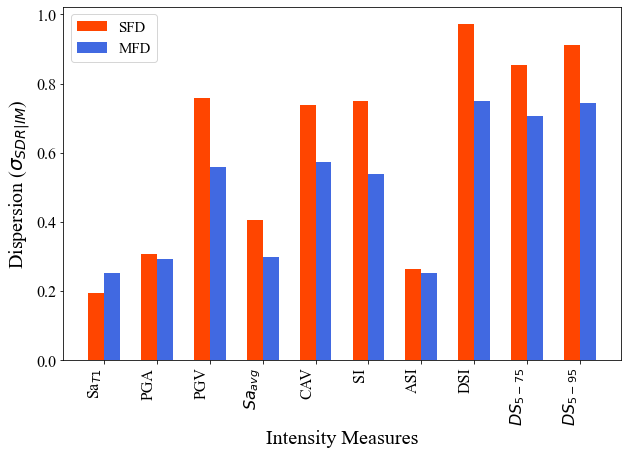

In [102]:
labels = [r'Sa$_{T1}$', 'PGA', 'PGV', r'$Sa_{avg}$', 'CAV', 'SI', 'ASI', 'DSI', r'$DS_{5-75}$',  r'$DS_{5-95}$' ]

meanSFD = SDR_mean['meanSFD'].values
meanMFD = SDR_mean['meanMFD'].values

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

set
rects1 = ax.bar(x - width/2, meanSFD, width, label='SFD', color = 'orangered')
rects2 = ax.bar(x + width/2, meanMFD, width, label='MFD', color = 'royalblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Dispersion ($\sigma_{SDR|IM}$)', fontsize = 20)
ax.set_xlabel('Intensity Measures', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha = 'right')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 15)
os.chdir(r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study/Paper/images')
plt.savefig('eff_regional_SDR.png', bbox_inches="tight")

0
1


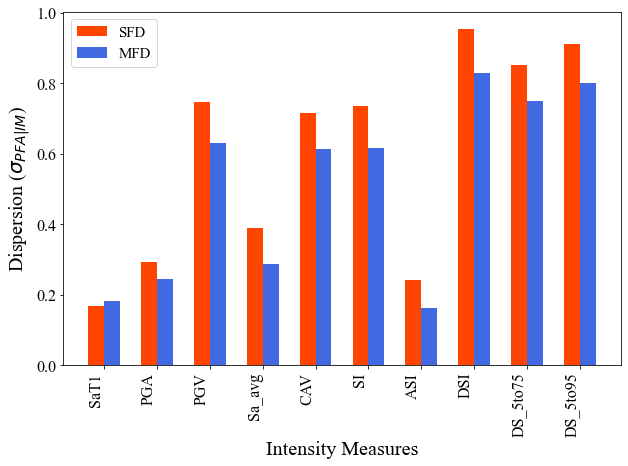

In [103]:
labels = IM_list

meanSFD = PFA_mean['meanSFD'].values
meanMFD = PFA_mean['meanMFD'].values

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6.5))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
rects1 = ax.bar(x - width/2, meanSFD, width, label='SFD', color = 'orangered')
rects2 = ax.bar(x + width/2, meanMFD, width, label='MFD', color = 'royalblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Dispersion ($\sigma_{PFA|IM}$)', fontsize = 20)
ax.set_xlabel('Intensity Measures', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90, ha = 'right')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 15)
os.chdir(r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study/Paper/images')
plt.savefig('eff_regional_PFA.png', bbox_inches="tight")

In [109]:
print(gminfo_rotD50.columns.tolist())

['PGA', 'PGV', 'DS_5to75', 'DS_5to95', 'CAV', 'T_0.01', 'T_0.02', 'T_0.03', 'T_0.04', 'T_0.05', 'T_0.06', 'T_0.07', 'T_0.08', 'T_0.09', 'T_0.10', 'T_0.11', 'T_0.12', 'T_0.13', 'T_0.14', 'T_0.15', 'T_0.16', 'T_0.17', 'T_0.18', 'T_0.19', 'T_0.20', 'T_0.21', 'T_0.22', 'T_0.23', 'T_0.24', 'T_0.25', 'T_0.26', 'T_0.27', 'T_0.28', 'T_0.29', 'T_0.30', 'T_0.31', 'T_0.32', 'T_0.33', 'T_0.34', 'T_0.35', 'T_0.36', 'T_0.37', 'T_0.38', 'T_0.39', 'T_0.40', 'T_0.41', 'T_0.42', 'T_0.43', 'T_0.44', 'T_0.45', 'T_0.46', 'T_0.47', 'T_0.48', 'T_0.49', 'T_0.50', 'T_0.51', 'T_0.52', 'T_0.53', 'T_0.54', 'T_0.55', 'T_0.56', 'T_0.57', 'T_0.58', 'T_0.59', 'T_0.60', 'T_0.61', 'T_0.62', 'T_0.63', 'T_0.64', 'T_0.65', 'T_0.66', 'T_0.67', 'T_0.68', 'T_0.69', 'T_0.70', 'T_0.71', 'T_0.72', 'T_0.73', 'T_0.74', 'T_0.75', 'T_0.76', 'T_0.77', 'T_0.78', 'T_0.79', 'T_0.80', 'T_0.81', 'T_0.82', 'T_0.83', 'T_0.84', 'T_0.85', 'T_0.86', 'T_0.87', 'T_0.88', 'T_0.89', 'T_0.90', 'T_0.91', 'T_0.92', 'T_0.93', 'T_0.94', 'T_0.95', 'T_0

In [174]:
sa_list = ['T_0.01', 'T_0.05', 'T_0.10', 'T_0.11', 'T_0.12', 'T_0.13', 'T_0.14', 'T_0.15', 'T_0.16', 'T_0.17',
           'T_0.18', 'T_0.19', 'T_0.20', 'T_0.21', 'T_0.22', 'T_0.23', 'T_0.24', 'T_0.25', 'T_0.26', 'T_0.27',
           'T_0.28', 'T_0.29', 'T_0.30', 'T_0.31', 'T_0.32', 'T_0.33', 'T_0.34', 'T_0.35', 'T_0.36', 'T_0.37',
           'T_0.38', 'T_0.39', 'T_0.40', 'T_0.41', 'T_0.42', 'T_0.43', 'T_0.44', 'T_0.45', 'T_0.46', 'T_0.47',
           'T_0.48', 'T_0.49', 'T_0.50']

SDR_mean, PFA_mean= portfolio_mean_efficiency(BuildingList, gminfo_rotD50, sa_list, average_EDP=True, Uni_Direction=True)      

In [175]:
# sa_list[0].split('_')[]
period_list = []
for ii in range(len(sa_list)):
    period_list.append(float(sa_list[ii].split('_')[1]))


In [213]:
SDR_mean['mean'] = SDR_mean.mean(axis=1)
SDR_mean['meanSFD'] = SDR_mean.loc[:,'SFD1B':'SFD4B'].mean(axis=1)
SDR_mean['meanMFD'] = SDR_mean.loc[:,'MFD1B':'MFD6B'].mean(axis=1)
SDR_mean['weighted_mean'] = SDR_mean[['meanSFD','meanMFD']].mean(axis=1)

PFA_mean['mean'] = PFA_mean.mean(axis=1)
PFA_mean['meanSFD'] = PFA_mean.loc[:,'SFD1B':'SFD4B'].mean(axis=1)
PFA_mean['meanMFD'] = PFA_mean.loc[:,'MFD1B':'MFD6B'].mean(axis=1)
PFA_mean['weighted_mean'] = PFA_mean[['meanSFD','meanMFD']].mean(axis=1)
PFA_mean.head(200)

,SFD1B,SFD3B,SFD2B,SFD4B,MFD1B,MFD4B,MFD2B,MFD5B,MFD3B,MFD6B,mean,meanSFD,meanMFD,weighted_mean
IM,,,,,,,,,,,,,,
T_0.01,0.25957,0.246375,0.27475,0.273376,0.260228,0.256419,0.228764,0.232999,0.167033,0.168553,0.237814,0.263518,0.218999,0.241259
T_0.05,0.214046,0.19587,0.239319,0.23926,0.248933,0.242244,0.232331,0.236166,0.202102,0.201468,0.225059,0.222123,0.227207,0.224665
T_0.10,0.130386,0.109448,0.159107,0.159065,0.214569,0.207671,0.234351,0.23593,0.26085,0.255743,0.194555,0.139501,0.234852,0.187177
T_0.11,0.1129,0.102558,0.142268,0.14199,0.202803,0.196095,0.228475,0.229194,0.260456,0.255391,0.184865,0.124929,0.228736,0.176832
T_0.12,0.102895,0.104081,0.120099,0.12195,0.19294,0.186004,0.221761,0.223122,0.262186,0.256428,0.176625,0.112256,0.223740,0.167998
T_0.13,0.105529,0.112419,0.102591,0.104933,0.183823,0.176257,0.218908,0.21974,0.264467,0.258242,0.172115,0.106368,0.220239,0.163304
T_0.14,0.118291,0.134534,0.09758,0.103764,0.173902,0.166351,0.211955,0.211844,0.262105,0.255083,0.171279,0.113542,0.213540,0.163541
T_0.15,0.139231,0.154488,0.111549,0.117309,0.169134,0.160501,0.207879,0.206506,0.261492,0.255226,0.176534,0.130644,0.210123,0.170384
T_0.16,0.158557,0.173169,0.12632,0.125788,0.158261,0.14978,0.201928,0.199485,0.261881,0.25574,0.179766,0.145958,0.204512,0.175235


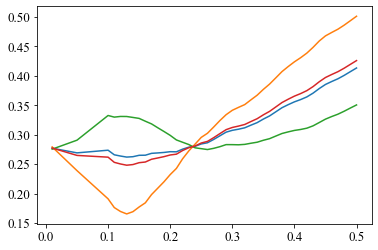

In [191]:
plt.plot(period_list, SDR_mean['mean'].values)
plt.plot(period_list, SDR_mean['meanSFD'].values)
plt.plot(period_list, SDR_mean['meanMFD'].values)
plt.plot(period_list, SDR_mean[['meanSFD','meanMFD']].mean(axis=1))

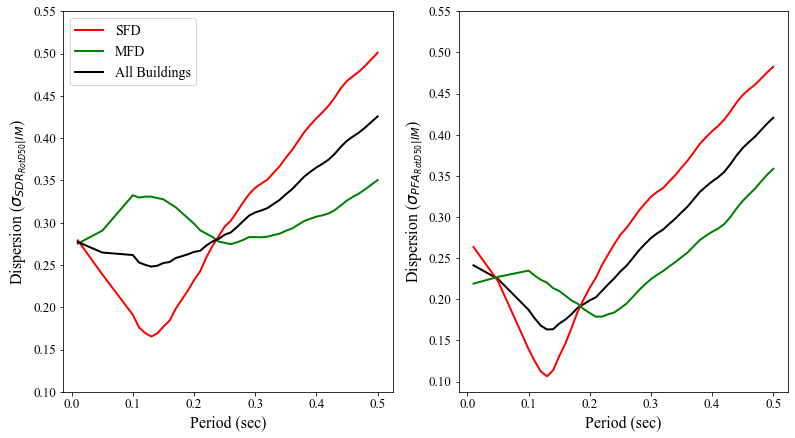

In [202]:
ytickList = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
fig, axs = plt.subplots(1, 2, figsize=(13,7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
markerList = ['.', '*', '+', 'o', 's', 'p', 'd', 'X', 'v', 'D', 'P']


axs[0].plot(period_list, SDR_mean['meanSFD'].values, label = 'SFD', linewidth =2, color = 'r')
axs[0].plot(period_list, SDR_mean['meanMFD'].values, label = 'MFD', linewidth =2, color = 'g')
# axs[0].plot(period_list, SDR_mean['mean'].values, label = 'All Buildings', linewidth =2, color = 'b')
axs[0].plot(period_list, SDR_mean['weighted_mean'].values, label = 'All Buildings', linewidth =2, color = 'k')
axs[0].set_ylabel(r'Dispersion ($\sigma_{SDR_{RotD50}|IM}$)', fontsize = 16)
axs[0].set_xlabel('Period (sec)', fontsize = 16)
axs[0].set_yticks(ytickList)
# axs[1].plot(period_list, PFA_mean['mean'].values, linewidth =2, color = 'b')
axs[1].plot(period_list, PFA_mean['weighted_mean'].values, linewidth =2, color = 'k')
axs[1].plot(period_list, PFA_mean['meanSFD'].values, linewidth =2, color = 'r')
axs[1].plot(period_list, PFA_mean['meanMFD'].values,linewidth =2, color = 'g')

axs[1].set_ylabel(r'Dispersion ($\sigma_{PFA_{RotD50}|IM}$)', fontsize = 16)
axs[1].set_xlabel('Period (sec)', fontsize = 16)
axs[1].set_yticks(ytickList)
axs[0].legend(loc= 'best', fontsize = 14)
os.chdir(r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study/Paper/images')
plt.savefig('period_benchmark.png', bbox_inches="tight")

In [204]:
SDR_mean[np.round(SDR_mean['weighted_mean'].values, 2) == np.round(SDR_mean['meanSFD'].values, 2)]

,SFD1B,SFD3B,SFD2B,SFD4B,MFD1B,MFD4B,MFD2B,MFD5B,MFD3B,MFD6B,mean,meanSFD,meanMFD,weighted_mean
IM,,,,,,,,,,,,,,
T_0.01,0.280656,0.259479,0.29418,0.28204,0.280088,0.289406,0.274719,0.255952,0.28065,0.271034,0.276884,0.279089,0.275308,0.277199
T_0.24,0.28969,0.283548,0.286371,0.275399,0.252855,0.276632,0.228084,0.218375,0.365153,0.32458,0.280171,0.283752,0.277613,0.280683


In [212]:
PFA_mean[np.round(PFA_mean['weighted_mean'].values, 2) == np.round(PFA_mean['meanSFD'].values, 2)]

,SFD1B,SFD3B,SFD2B,SFD4B,MFD1B,MFD4B,MFD2B,MFD5B,MFD3B,MFD6B,mean,meanSFD,meanMFD,weighted_mean
IM,,,,,,,,,,,,,,
T_0.05,0.214046,0.19587,0.239319,0.23926,0.248933,0.242244,0.232331,0.236166,0.202102,0.201468,0.225089,0.222123,0.227207,0.224665


In [132]:
SDR_mean['meanSFD'].idxmin()

'T_0.13'

In [206]:
SDR_mean['weighted_mean'].idxmin()

'T_0.13'

In [211]:
(SDR_mean.loc['T_0.24','weighted_mean'] - SDR_mean['weighted_mean'].min())*100/SDR_mean['weighted_mean'].min()

13.149849760699771

In [214]:
(PFA_mean.loc['T_0.19','weighted_mean'] - PFA_mean['weighted_mean'].min())*100/PFA_mean['weighted_mean'].min()

18.809713666296116

In [134]:
PFA_mean['meanSFD'].idxmin()

'T_0.13'

In [135]:
SDR_mean['meanMFD'].idxmin()

'T_0.26'

In [208]:
PFA_mean['weighted_mean'].idxmin()

'T_0.13'

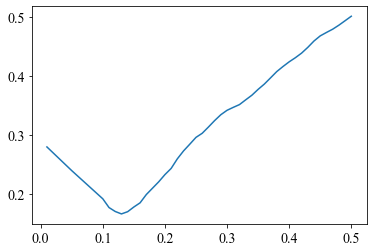

In [137]:
plt.plot(period_list, SDR_mean['meanSFD'].values)

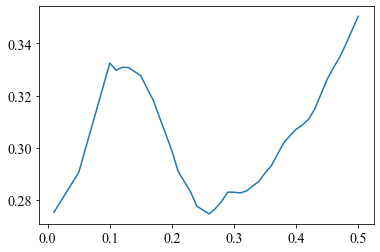

In [138]:
plt.plot(period_list, SDR_mean['meanMFD'].values)

In [ ]:
SDR_mean['mean'].plot(kind = 'bar')

In [ ]:
SDR_mean['mean'].plot(kind = 'bar')

In [ ]:
PFA_mean['mean'].plot(kind = 'bar')

In [ ]:
buildingName = ['IM', 'SFD1B', 'SFD3B', 'SFD2B', 'SFD4B', 'MFD1B', 'MFD4B', 'MFD2B', 'MFD5B', 'MFD3B', 'MFD6B']
df = pd.DataFrame(data = [], columns=buildingName)
df = df.set_index('IM')

In [ ]:
df.loc['SaT1','SFD1B'] = np.mean(s1_48x32_high.loc['SaT1'][::2].values)
df.head()

In [ ]:
# ### Not used for now as the focus is dispersion not the median value
# def plot_empirical_EDP(buildingIndex, EDP = 'SDR', separate_direction = False):
#     dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
#     os.chdir(dataDir)
#     if EDP == 'SDR':
#         edp = pd.read_csv('SDR.csv', header = None)
#         start_index = 3 #for dataframe
#     elif EDP == 'PFA':
#         edp = pd.read_csv('PFA.csv', header = None)
#         start_index = 4
#     else:
#         print('Enter Valid EDP')
#         sys.exit(1)
    
#     if separate_direction:
#         start = 0
#         increment = 2
#     else:
#         start = 0
#         increment = 1
        
        
#     edpX = edp[:numGM][start::increment]
#     edpY = edp[numGM:numGM*2][start::increment]
    
#     numStory = int(BuildingList[buildingIndex].split('_')[0][1])
#     floor = np.arange(1, numStory + 1)
    
#     median_edpX = np.zeros(shape = numStory)
#     median_edpY = []
#     logstd_edpX = []
#     logstd_edpY = []
    
#     for i in range(numStory):
#         median_edpX[i] = np.median(edpX[start_index + i].values[:numGM])
#         median_edpY.append(np.median(edpY[start_index + i].values[:numGM]))
#         logstd_edpX.append(np.std(np.log(edpX[start_index + i].values[:numGM])))
#         logstd_edpY.append(np.std(np.log(edpY[start_index + i].values[:numGM])))
    
#     fig, axs = plt.subplots(2, 2)
#     axs[0, 0].plot(median_edpX[::-1], floor)
#     axs[0, 0].set_title('Median X')
#     axs[0, 1].plot(logstd_edpX, floor, 'tab:green')
#     axs[0, 1].set_title('Axis [1, 0]')
    
#     axs[1, 0].plot(median_edpY[::-1], floor, 'tab:orange')
#     axs[1, 0].set_title('Axis [0, 1]')
    
#     axs[1, 1].plot(logstd_edpY[::-1], floor, 'tab:red')
#     axs[1, 1].set_title('Axis [1, 1]')

#     for ax in axs.flat:
#         ax.set(xlabel='x-label', ylabel='y-label')

#     # Hide x labels and tick labels for top plots and y ticks for right plots.
#     for ax in axs.flat:
#         ax.label_outer()
# #     print(median_edpX)

# # plot_efficiency(9, 'SDR')
    

In [ ]:
s4_96x48_high_suff = SummaryResutls_sufficiency(9, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=True)
s4_96x48_high_suff.T

In [ ]:
s4_96x48_high_suff = SummaryResutls_sufficiency(9, gminfo_rotD50, IM_list, pairingID = 1, fit_residual=True, average_EDP=True)
s4_96x48_high_suff.T

In [ ]:
s4_96x48_high_suff = SummaryResutls_sufficiency(8, gminfo_h1, IM_list, pairingID = 1, fit_residual=True)
s4_96x48_high_suff.T

In [15]:
def save_data_for_R(buildingIndex, df_IMs, IMs=['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV'], pairingID = 1, 
                   average_EDP = False, rotate_EDP = False):
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
    os.chdir(dataDir)
    sdr = pd.read_csv('SDR.csv', header = None)
    pfa = pd.read_csv('PFA.csv', header = None)
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
    
    
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    temp = {}
    for i in range(numStory):
        ## geometric average of EDP (in X and Z direction) between pairing ID 1 and 2
        if average_EDP:
            name_suffix = 'avg_EDP'
            sdrX = gmean([sdr[3+i].values[0:numGM], sdr[3+i].values[numGM*2:numGM*3]])
            pfaX = gmean([pfa[4+i].values[0:numGM], pfa[4+i].values[numGM*2:numGM*3]])

            sdrZ = gmean([sdr[3+i].values[numGM:numGM*2], sdr[3+i].values[numGM*3:numGM*4]])
            pfaZ = gmean([pfa[4+i].values[numGM:numGM*2], pfa[4+i].values[numGM*3:numGM*4]])
            
            if rotate_EDP:
                name_suffix = 'rot_EDP'
                sdr_rotD50 = compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
                pfa_rotD50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
            
        else:
            name_suffix = 'pID%s'%pairingID
            sdrX = sdr[3+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            sdrZ = sdr[3+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

            pfaX = pfa[4+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            pfaZ = pfa[4+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
        
        if rotate_EDP:
            temp['story_%s_SDR_rotD50'%(i+1)] = sdr_rotD50
            temp['story_%s_PFA_rotD50'%(i+1)] = pfa_rotD50
        else:
            temp['story_%s_sdrX'%(i+1)] = sdrX
            temp['story_%s_sdrZ'%(i+1)] = sdrZ
            temp['story_%s_pfaX'%(i+1)] = pfaX
            temp['story_%s_pfaZ'%(i+1)] = pfaZ
    
    for i in range(len(IMs)):
        if IMs[i] == 'SaT1':
            temp[IMs[i]] = df_IMs['T_%s'%T[buildingIndex]].values
        else:
            temp[IMs[i]] = df_IMs[IMs[i]]
    temp['Magnitude'] = df_IMs['Magnitude']
    temp['Distance_Rjb'] = df_IMs['Distance_Rjb']
    temp['Distance_rup'] = df_IMs['Distance_rup']
    final_df = pd.DataFrame(temp)
#     final_df.to_csv('Inputs_for_%s_%s.csv'%(BuildingList[buildingIndex], name_suffix))
    return final_df

In [ ]:
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
for ii in range(len(BuildingList)):
    save_data_for_R(ii, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=False)


In [ ]:
df_comb = save_data_for_R(9, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=True)
df_comb.head()

In [16]:
df_comb = save_data_for_R(9, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=False)
df_comb1 = save_data_for_R(4, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=False)
df_comb1.head()

,story_1_sdrX,story_1_sdrZ,story_1_pfaX,story_1_pfaZ,story_2_sdrX,story_2_sdrZ,story_2_pfaX,story_2_pfaZ,SaT1,PGA,...,Sa_avg,CAV,SI,ASI,DSI,DS_5to75,DS_5to95,Magnitude,Distance_Rjb,Distance_rup
GMID,,,,,,,,,,,,,,,,,,,,,
GM1_RSN9,0.000391,0.000450,0.125470,0.127281,0.000208,0.000217,0.184655,0.177877,113.556545,36.502124,...,88.184618,283.719540,23.862338,52.239226,15.522318,19.685,34.455,6.50,56.88,56.88
GM2_RSN12,0.000317,0.000319,0.102063,0.099908,0.000158,0.000162,0.141829,0.130835,111.124256,41.268564,...,108.306517,366.517457,31.550051,48.979590,29.362105,17.045,29.345,7.36,114.62,117.75
GM3_RSN30,0.004204,0.003188,0.587833,0.539026,0.001091,0.000813,0.685987,0.638323,690.226425,267.680106,...,432.395587,488.062285,72.350526,332.892287,29.018868,2.170,7.520,6.19,9.58,9.58
GM4_RSN31,0.001509,0.001585,0.334292,0.590095,0.000613,0.000634,0.466129,0.706384,816.872820,213.757067,...,263.701266,376.026733,41.966040,182.466462,22.814141,3.840,10.840,6.19,12.90,12.90
GM5_RSN36,0.000464,0.000472,0.142974,0.127732,0.000214,0.000224,0.187433,0.160976,175.756471,44.924604,...,140.320730,511.568742,67.155975,64.886716,49.462109,24.580,48.150,6.63,45.12,45.66


In [18]:
df_comb.columns

Index(['story_1_sdrX', 'story_1_sdrZ', 'story_1_pfaX', 'story_1_pfaZ',
       'story_2_sdrX', 'story_2_sdrZ', 'story_2_pfaX', 'story_2_pfaZ',
       'story_3_sdrX', 'story_3_sdrZ', 'story_3_pfaX', 'story_3_pfaZ',
       'story_4_sdrX', 'story_4_sdrZ', 'story_4_pfaX', 'story_4_pfaZ', 'SaT1',
       'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI', 'DS_5to75',
       'DS_5to95', 'Magnitude', 'Distance_Rjb', 'Distance_rup'],
      dtype='object')

In [20]:
# plt.figure(figsize=(10,10))
# sns.heatmap(np.log(df_comb.loc[:,'story_1_sdrX':'story_4_pfaZ']).corr(), cmap= 'crest');

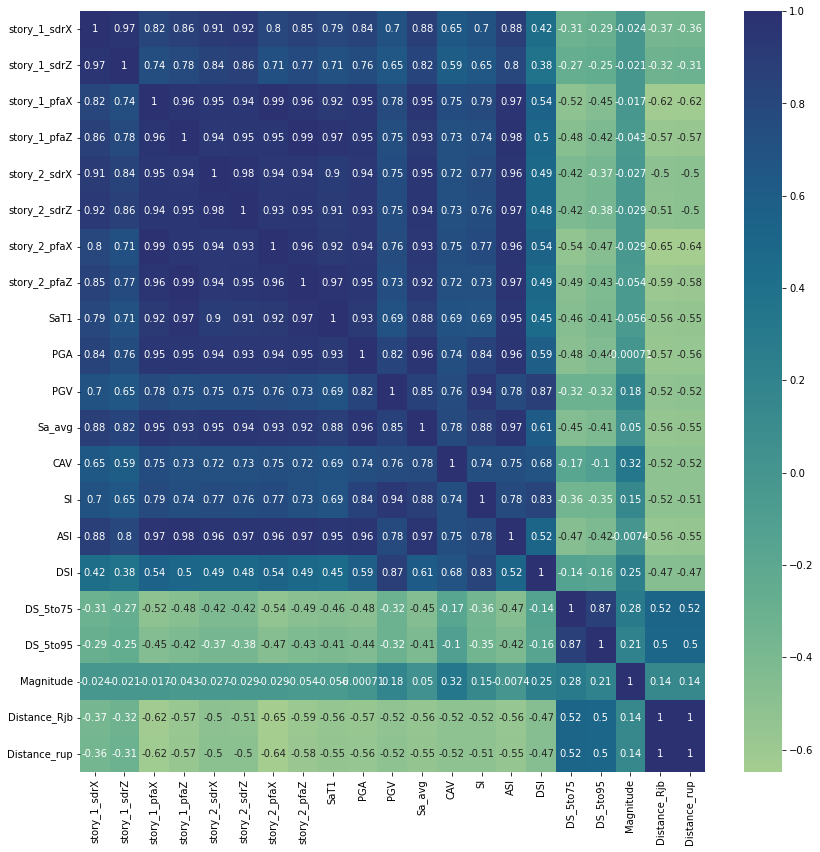

In [21]:
plt.figure(figsize=(14,14))
sns.heatmap(df_comb1.corr(), cmap= 'crest', annot=True);

In [ ]:
df_comb1.cov()

In [22]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [ ]:
correlation_from_covariance(df_comb1.loc[:,'story_1_sdrX':'story_%d_pfaZ'%2].cov())

In [ ]:
correlation_from_covariance([[1, 0.5], [0.5, 2]])

In [ ]:
gminfo_rotD50.columns

In [23]:
def plot_correlation(buildingIndex, df_IMs, IMs, average_EDP = True, rotate_EDP = False,
                     savefig = False):
    summary_df = save_data_for_R(buildingIndex, df_IMs, IMs, pairingID=1,
                                 average_EDP=average_EDP, rotate_EDP=rotate_EDP)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    if rotate_EDP:
        tickList = [r'Floor 1 SDR$_{RotD50}$',r'Floor 1 PFA$_{RotD50}$',
                    r'Floor 2 SDR$_{RotD50}$',r'Floor 2 PFA$_{RotD50}$',
                    r'Floor 3 SDR$_{RotD50}$',r'Floor 3 PFA$_{RotD50}$',
                    r'Floor 4 SDR$_{RotD50}$',r'Floor 4 PFA$_{RotD50}$']
        corr = summary_df.loc[:,'story_1_SDR_rotD50':'story_%d_PFA_rotD50'%numStory].corr()
    else:
        tickList = [r'Floor 1 SDR$_X$', r'Floor 1 SDR$_Z$',r'Floor 1 PFA$_X$', r'Floor 1 PFA$_Z$',
                    r'Floor 2 SDR$_X$', r'Floor 2 SDR$_Z$',r'Floor 2 PFA$_X$', r'Floor 2 PFA$_Z$',
                    r'Floor 3 SDR$_X$', r'Floor 3 SDR$_Z$',r'Floor 3 PFA$_X$', r'Floor 3 PFA$_Z$',
                    r'Floor 4 SDR$_X$', r'Floor 4 SDR$_Z$',r'Floor 4 PFA$_X$', r'Floor 4 PFA$_Z$']

        corr = summary_df.loc[:,'story_1_sdrX':'story_%d_pfaZ'%numStory].corr()
    
    plt.figure(figsize=(10,10))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    sns.heatmap(corr, cmap="Greens",annot=True, annot_kws={"fontsize":'large'},
                xticklabels=tickList[:numStory*4], yticklabels=tickList[:numStory*4])
    
    if savefig:
        os.chdir(r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study/Paper/images')
        plt.savefig('%s_corrPlot.png'%BuildingList[buildingIndex], bbox_inches="tight")
    else:
        plt.show()

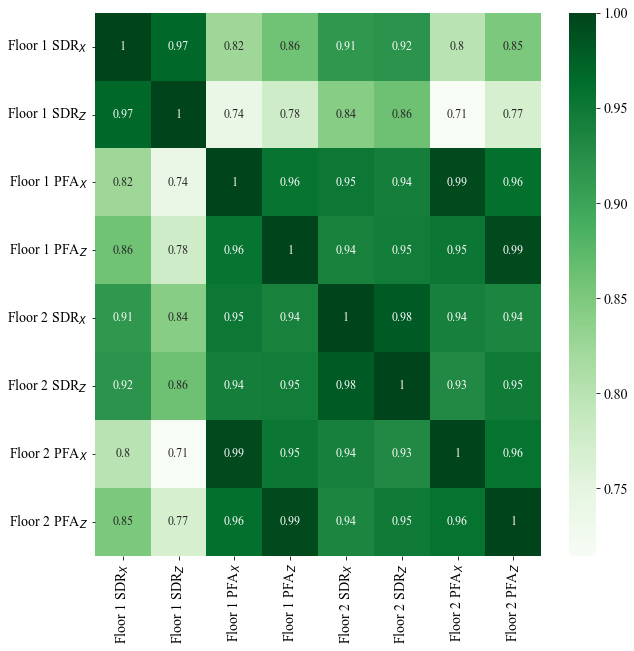

In [24]:
plot_correlation(4, gminfo_rotD50, IM_list, average_EDP = True, rotate_EDP = False, savefig = True)

In [ ]:
plt.figure(figsize=(10,10))
corr = df_comb1.loc[:,'story_1_sdrX':'story_2_pfaZ'].corr()
tickList = [r'Floor 1 SDR$_X$', r'Floor 1 SDR$_Z$',r'Floor 1 PFA$_X$', r'Floor 1 PFA$_Z$',
            r'Floor 2 SDR$_X$', r'Floor 2 SDR$_Z$',r'Floor 2 PFA$_X$', r'Floor 2 PFA$_Z$']
# corr.style.background_gradient(cmap = 'coolwarm')
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True, annot_kws={"fontsize":'x-large'}, xticklabels=tickList, yticklabels=tickList)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
corr = df_comb1.loc[:,'story_1_sdrX':'story_2_pfaZ'].corr()
tickList = [r'Floor 1 SDR$_X$', r'Floor 1 SDR$_Z$',r'Floor 1 PFA$_X$', r'Floor 1 PFA$_Z$',
            r'Floor 2 SDR$_X$', r'Floor 2 SDR$_Z$',r'Floor 2 PFA$_X$', r'Floor 2 PFA$_Z$']
# corr.style.background_gradient(cmap = 'coolwarm')
plt.figure(figsize=(11,8))
sns.pairplot(np.log(df_comb1.loc[:,'story_1_sdrX':'story_2_pfaZ']), kind="kde")
plt.show()

In [25]:
from scipy.stats import chi2_contingency

def calc_MI(x, y, bins):
    '''
    Calculates mutual information
    '''
    c_xy = np.histogram2d(x, y, bins)[0]
    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood", correction=False)
    mi = 0.5 * g / c_xy.sum()
    return mi

In [67]:
calc_MI(np.log(df_comb1['SaT1'].values), np.log(df_comb1['SaT1'].values), bins = 23)

2.86097841481566

In [36]:
calc_MI(np.log(df_comb1['story_1_sdrX'].values), np.log(df_comb1['story_1_sdrX'].values), bins = 16)

2.387067746938215

In [85]:
calc_MI(np.log(df_comb1['story_1_sdrX'].values), np.log(df_comb1['Distance_Rjb'].values), bins = 13)

0.5951640611212174

In [92]:
calc_MI(np.log(df_comb1['Distance_Rjb'].values), np.log(df_comb1['Distance_Rjb'].values), bins = 13)

1.801746785568513

In [82]:
calc_MI(np.log(df_comb1['SaT1'].values), df_comb1['Magnitude'].values, bins = 15)

0.2731504363498451

In [95]:
calc_MI(np.log(df_comb1['Distance_Rjb'].values), df_comb1['Magnitude'].values, bins = 13)

0.24713927993779908

In [88]:
calc_MI(df_comb1['Magnitude'].values, df_comb1['Magnitude'].values, bins = 15)

2.2417363405451156

In [ ]:
calc_MI(df_comb1.loc[:,'story_1_sdrX'].values, df_comb1.loc[:,'story_1_sdrX'].values, 5)

In [ ]:
0.5 * -np.log(1-0.96**2)

In [ ]:
0.5 * -np.log(1-0.77**2)

In [39]:
0.5 * -np.log(1-0.999**2)

3.1075541117319436

In [ ]:
calc_MI(df_comb1.loc[:,'story_2_pfaZ'].values, df_comb1.loc[:,'story_1_sdrX'].values, 5)

In [ ]:
for ii in range(len(BuildingList)):
    save_data_for_R(ii, gminfo_rotD50, IM_list, pairingID=1, average_EDP=True, rotate_EDP=True)

In [ ]:
s2_48x32_high= SummaryResutls_efficiency(4, ['SaT1', 'PGA', 'PGV'])
s2_48x32_high

In [ ]:
s4_96x48_high= SummaryResutls_efficiency(8, ['SaT1', 'PGA', 'PGV', 'Sa_avg'])
s4_96x48_high

In [ ]:
s4_96x48_veryhigh= SummaryResutls_efficiency(9, ['SaT1', 'PGA', 'PGV', 'Sa_avg'])
s4_96x48_veryhigh

Combining all the data efficiency into a big data frame.

In [ ]:
d = []
for i in range(len(BuildingList)):
    d.append(SummaryResutls_efficiency(i, ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV']))

finaldf = pd.concat(d, keys = BuildingList)
finaldf.head(50)

## Debugging

In [ ]:
def compute_RotDxx_EDP(edpX, edpZ, percentile = 50):
    angles = np.arange(0, 180, step=1)
    radians = np.radians(angles)
    coeffs = np.c_[np.cos(radians), np.sin(radians)]
    
    edp_stacked = np.vstack([edpX, edpZ])
    rotated_edp = np.dot(coeffs, edp_stacked)
    percentile_edp = np.percentile(rotated_edp, q = percentile, axis = 0, interpolation='linear')
    return percentile_edp

In [ ]:
buildingIndex = 9
pairingID = 1
IMs = 'SaT1'
numGM = 826

if pairingID == 1:
    start_index_multiplier = 0
    end_index_multiplier = 1
else:
    start_index_multiplier = 2
    end_index_multiplier = 3

if IMs == 'SaT1':
    IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
else:
    IM = gminfo_rotD50[IMs]
    
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'
dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])

os.chdir(dataDir)
sdr = pd.read_csv('SDR.csv', header = None)
pfa = pd.read_csv('PFA.csv', header = None)

#story index
i = 0
j = 0
sdrX = sdr[3+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
sdrZ = sdr[3+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

pfaX = pfa[4+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
pfaZ = pfa[4+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

sdr_rotd50 = compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
pfa_rotd50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
X = sm.add_constant(np.log(IM))

sdrX_avg = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
pfaX_avg = gmean([pfa[3+j].values[0:numGM], pfa[3+j].values[numGM*2:numGM*3]])

sdrZ_avg = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
pfaZ_avg = gmean([pfa[3+j].values[numGM:numGM*2], pfa[3+j].values[numGM*3:numGM*4]])
print(pfaZ_avg.shape)
#                 compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
#                 pfa_rotD50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
ols_sdrX = OLS(sdrX_avg, IM)
ols_sdrZ = OLS(sdrZ_avg, IM)
ols_pfaX = OLS(pfaX_avg, IM)
ols_pfaZ = OLS(pfaZ_avg, IM)

In [ ]:
calc_MI(gminfo_rotD50['Magnitude'].values, ols_pfaX.result.resid, bins = 8)

In [ ]:
calc_MI(gminfo_rotD50['Distance_Rjb'].values, ols_pfaX.result.resid, bins=8)

In [ ]:
calc_MI(gminfo_rotD50['Distance_Rjb'].values, gminfo_rotD50['Magnitude'].values, bins=15)

In [ ]:
calc_MI(IM, gminfo_rotD50['Magnitude'].values, bins=8)

In [ ]:
calc_MI(IM, gminfo_rotD50['Distance_Rjb'].values, bins=8)

In [ ]:
calc_MI(IM, sdrZ_avg, bins=6)

In [ ]:
calc_MI(np.log(sdrZ_avg), np.log(sdrZ_avg), bins=14)

In [ ]:
calc_MI(IM, IM, bins=8)

In [ ]:
pfa.shape

In [ ]:
sdrgmean = gmean([sdrX, sdrZ])
sdr.shape

In [ ]:
np.exp(np.mean([np.log(sdrX[0]), np.log(sdrZ[0])]))

In [ ]:
np.sqrt(sdrX[0]**2 + sdrZ[0]**2)

In [ ]:
angles = np.arange(0, 180, step=1)
radians = np.radians(angles)
coeffs = np.c_[np.cos(radians), np.sin(radians)]
sdr_stacked = np.vstack([sdrX, sdrZ])
rotated_sdr = np.dot(coeffs, sdr_stacked)

In [ ]:
percentile_sdr = np.percentile(rotated_sdr, 50, axis = 0, interpolation='linear')
percentile_sdr.shape

In [ ]:
np.median(rotated_sdr)

In [ ]:
testEff = OLS(sdrX, IM)
np.std(testEff.result.resid)

In [ ]:
testEff = OLS(sdr, IM)
np.std(testEff.result.resid)


In [ ]:
# testSuff = sm.OLS(testEff.result.resid, sm.add_constant(np.log(gminfo_rotD50['Distance_Rjb'])))
testSuff = sm.OLS(testEff.result.resid, sm.add_constant(np.log(gminfo_rotD50['Magnitude'])))

testSuff.fit().summary()


In [ ]:
testSuff.fit().pvalues


In [ ]:
##### Using residual from efficiency to compute sufficiency instead of direct linear model

temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
##### Using residual from efficiency to compute sufficiency instead of direct linear model

temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdr),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues

In [ ]:
# I = np.ones(shape = numGM)
# Y = np.log()
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'M': gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
# I = np.ones(shape = numGM)
# Y = np.log()
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values)}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues

In [ ]:
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues

In [ ]:
sdrXx = sdr[3].values[:numGM][1::2]
len(sdrXx)

In [ ]:
linear_fit = sm.OLS(np.log(sdrX), X)
fit_result = linear_fit.fit()
fit_result.summary()

In [ ]:
np.std(fit_result.resid)

In [ ]:
linear_fit = sm.OLS(np.log(sdrXx), Xx)
fit_result = linear_fit.fit()
fit_result.summary()

In [ ]:
np.std(fit_result.resid)

In [ ]:
temp = {'I': np.ones(shape = 240),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues['lnRjb']

a = 'Yes' if model_res.pvalues['lnRjb'] >= 0.05 else 'No'

In [ ]:
np.round(model_res.pvalues['lnRjb'], 2)



In [ ]:
temp = {'I': np.ones(shape = 240),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
sns.histplot(fit_result.resid)

In [ ]:
mu, std = norm.fit(fit_result.resid)
mu, std

In [ ]:
np.std(fit_result.resid)

In [ ]:
np.std(fit_result.resid)

In [ ]:
np.std(fit_result.resid)

In [ ]:
ols_sdrX_saT1 = OLS(sdrX, sa_T013)

In [ ]:
ols_sdrX_saT1.get_summary()

In [ ]:
ols_sdrX_saT1.plot_model_fit()

In [ ]:
ols_sdrX_saT1.plot_residuals_hist()

In [ ]:
# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
ax2.set_title('Not Shaded')

plt.show()

In [ ]:
x


In [ ]:
y

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, z in zip(['r', 'g', 'b', 'y'], [30, 20, 10, 0]):
    xs = np.arange(20)
    ys = np.random.rand(20)

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
z